Short Example for use of propagator.py functions to generate JSA for double pass poled crystals.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from NeedALight.propagator import Hprop, Total_prog, JSA, phases
from custom_poling.core.target import Target
from custom_poling.core.custom_crystal import CustomCrystal
from tqdm import tqdm
%config InlineBackend.figure_formats=['svg']

This section introduces all relevant quantities needed to use the functions and generate the wanted properties.

In [2]:
N = 501  # Number of frequency values
Np = 0.00006 # Number of pump photons  0.6 for ~10 NS double pass
vp = 0.1  # pump velocity
l = 1.0  # amplification region length
sig = 1  # pump wave packet spread
a = 1.61 / 1.13  # from symmetric grp vel matching

def symmetric_v(vp, sig, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sig))
    vs = vp / (1 + 2 * a * vp / (l * sig))
    return vs, vi

vs, vi = symmetric_v(vp, sig, l, a)

#Frequency values
wi = -10
wf = 10
dw = (wf - wi) / (N - 1)
x = np.linspace(wi, wf, N)

#Defining gaussian pump pulse
def pump(x, scale=1):
    return np.exp(-((x) ** 2) / (2 * (sig*scale) ** 2)) / np.power(np.pi * (sig*scale), 1 / 4)



# Crystal properties
Ndomain = 1000
dz = l / Ndomain
domain_width = dz
number_domains = Ndomain
L = number_domains * domain_width
k0 = np.pi / domain_width

# Numerical integration parameters for generating domain
k_range = 100/L
dk = k_range/401
k_array = np.arange(k0-k_range/2,k0+k_range/2,dk)


Here we generate the wanted crystal with the proper domain. The domain will produce a gaussian phase-matching function. We use the code and follow the examples of Agata Branczyk: https://github.com/abranczyk/custom-poling

In [3]:
# Create a custom crystal object
custom_crystal_gauss = CustomCrystal(domain_width,number_domains)
domain_middles_gauss = custom_crystal_gauss.domain_middles

#Define and plot the target function
std = 10
height = 0.025
target_pmf_gauss = lambda k:1j*height*np.exp(-(k-k0)**2/(2*std**2))*np.exp(1j * L/2 * k)
target_gauss = Target(target_pmf_gauss,k_array)

# Compute and plot the target amplitude
target_amplitude_gauss = target_gauss.compute_amplitude(k0,domain_middles_gauss)

# Compute and plot the custom domains
custom_domains_gauss = custom_crystal_gauss.compute_domains(target_amplitude_gauss,k0)
domain = custom_domains_gauss * np.asarray([1, -1] * int(Ndomain / 2)+[1])


#Proper scale factor so that Gaussian PMF and Gaussian Pump have the same width
sc=std/(2*a)

For the double pas structure, we generate the total propagators for each crystal and find the full propagator by multiplying both. We then break the full propagator into blocks and construct the N and M moments. From the M moments, we conduct a Singular Value decomposition and obtain the Joint Spectral Amplitude from it.

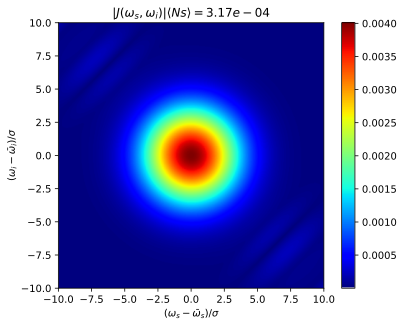

1.006847294611425


In [4]:
#Pass 1
pumpscaled=lambda x: pump(x, scale=sc)
prod1, P1, Nm1  = Hprop(Np, vs, vi, vp, dz, x, pumpscaled,4)
T1 = Total_prog(domain, prod1, P1, Nm1)
#Pass 2 
pumpscaled=lambda x: pump(x, scale=sc)
prod2, P2, Nm2  = Hprop(Np, vi, vs, vp, dz, x, pumpscaled,4)  #Swapped signal and idler velocities (to mimic polarization swap). Can also modify Np
T2 = Total_prog(np.flip(domain), prod2, P2, Nm2) #Flipped domain to mimic passing through in reverse.

#Combining both Passes and Obtaining JSA
U = T2 @ T1
N2 = len(U)
Uss = U[0 : N2 // 2, 0 : N2 // 2]
Usi = U[0 : N2 // 2, N2 // 2 : N2]
Uiss = U[N2 // 2 : N2, 0 : N2 // 2]
# Constructing the moment matrix
M = Uss @ (np.conj(Uiss).T)
# Using SVD of M to construct JSA
L, s, Vh = np.linalg.svd(M)
Sig = np.diag(s)
D = np.arcsinh(2 * Sig) / 2
J = L @ D @ Vh / dw
# Number of signal photons
Nums = np.conj(Usi) @ Usi.T
Numi = Uiss @ (np.conj(Uiss).T)
Ns = np.real(np.trace(Nums))
# Finding K
K = (np.trace(np.sinh(D) ** 2)) ** 2 / np.trace(np.sinh(D) ** 4)

fig, ax = plt.subplots()

im = ax.imshow(np.abs(J), cmap="jet", origin="lower", extent=[x[0],x[N-1],x[0],x[N-1]])
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
ax.set_title(r"$|J(\omega_{s}, \omega_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()
#plt.savefig("2pjsahigh.pdf")
print(K)

Next we begin by removing the free propagation phases from the total propagators and obtain the Scmidt modes. We plot the JSA again to show that it remains unchanged.

In [5]:
#Removing the Free propagation phases
T1T = phases(T1, vs, vi, vp, l, x)
T2T = phases(T2, vi, vs, vp, l, x)
U2 = T2T @ T1T
N3 = len(U2)
Uss = U2[0 : N3 // 2, 0 : N3 // 2]
Usi = U2[0 : N3 // 2, N3 // 2 : N3]
Uiss = U2[N3 // 2 : N3, 0 : N3 // 2]
# Constructing the moment matrix
M = Uss @ (np.conj(Uiss).T)
# Using SVD of M to construct JSA
L, s, Vh = np.linalg.svd(M)
Sig = np.diag(s)
D = np.arcsinh(2 * Sig) / 2
J = L @ D @ Vh / dw
# Number of signal photons
Nums = np.conj(Usi) @ Usi.T
Numi = Uiss @ (np.conj(Uiss).T)
Ns = np.real(np.trace(Nums))
# Finding K
K = (np.trace(np.sinh(D) ** 2)) ** 2 / np.trace(np.sinh(D) ** 4)

We obtain the Schmidt modes from the N matrix and plot the first relevant mode. Note that we multiply by a phase factor such that the imaginary part is 0 at the origin.

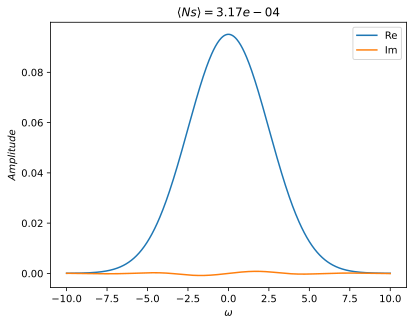

In [6]:
#Looking at the temporal modes via Nums matrix
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val, u = np.linalg.eigh(Nums)

fig, ax1 = plt.subplots()

ax1.plot(x, np.real(np.exp(-1j*np.angle(u[(N-1)//2,-mark]))*u[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(x, np.imag(np.exp(-1j*np.angle(u[(N-1)//2,-mark]))*u[:,-mark]), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()

plt.show()


Here we calculate the fidelity/overlap between a fixed low-gain Schmidt mode and another one with variable gain. We loop over different pump strengths.

In [7]:
#Overlaps for dual passes with different Strengths (each pass has same strength)
npi = 0.00006
npf = 0.6429
nstep = 15
step = (npf - npi)/nstep
num_pump = np.arange(npi,npf,step)
nsv = np.zeros_like(num_pump)
K = np.zeros_like(num_pump)
Temp_mode = np.zeros([len(x), len(num_pump)],dtype= np.complex128)
overlap = np.zeros(len(num_pump))


for i in tqdm(range(np.size(num_pump))):   
    prod1, P1, Nm1  = Hprop(num_pump[i], vs, vi, vp, dz, x, pumpscaled,4)
    T1 = Total_prog(domain, prod1, P1, Nm1)
    #Pass 2 
    pumpscaled=lambda x: pump(x, scale=sc)
    prod2, P2, Nm2  = Hprop(num_pump[i], vi, vs, vp, dz, x, pumpscaled,4)  #Swapped signal and idler velocities (to mimic polarization swap). Can also modify Np
    T2 = Total_prog(np.flip(domain), prod2, P2, Nm2)

    #Combining both Passes and Obtaining JSA
    U = T2 @ T1
    N4 = len(U)
    Uss = U[0 : N4 // 2, 0 : N4 // 2]
    Usi = U[0 : N4 // 2, N4 // 2 : N4]
    Uiss = U[N4 // 2 : N4, 0 : N4// 2]
    # Constructing the moment matrix
    M = Uss @ (np.conj(Uiss).T)
    # Using SVD of M to construct JSA
    L, s, Vh = np.linalg.svd(M)
    Sig = np.diag(s)
    D = np.arcsinh(2 * Sig) / 2
    J = L @ D @ Vh / dw
    # Number of signal photons
    Nums = np.conj(Usi) @ Usi.T
    Numi = Uiss @ (np.conj(Uiss).T)
    Ns = np.real(np.trace(Nums))
    # Finding K
    K[i] = (np.trace(np.sinh(D) ** 2)) ** 2 / np.trace(np.sinh(D) ** 4)
    nsv[i] = Ns

    w, v = np.linalg.eigh(Nums)
    Temp_mode[:,i] = v[:,-1]
overlapmat = np.abs(np.conj(Temp_mode).T @ Temp_mode) ** 2
overlap[:] = overlapmat[0,:]

100%|██████████| 15/15 [06:34<00:00, 26.29s/it]


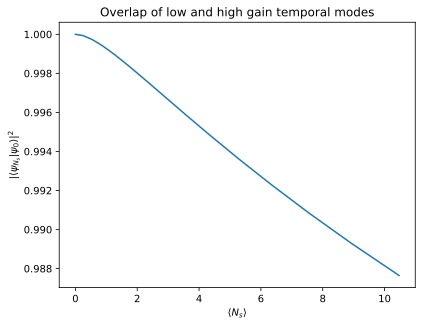

In [8]:
#Plotting Overlaps as a function of Ns
fig, ax = plt.subplots()
ax.plot(nsv, overlap)
ax.set_xlabel(r"$\langle N_{s} \rangle$")
ax.set_ylabel(r"$\left| \langle  \psi_{N_{s}}  | \psi_{0}   \rangle \right|^{2}$")
ax.set_title("Overlap of low and high gain temporal modes")
plt.show()

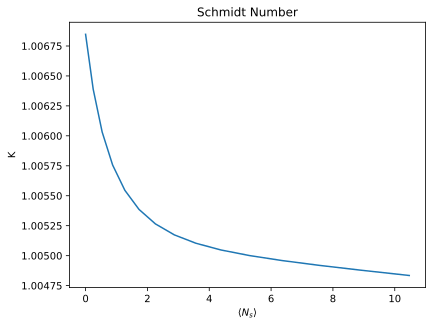

In [9]:
#Plotting Schmidt Number as a function of Ns
fig, ax = plt.subplots()
ax.plot(nsv, K)
ax.set_xlabel(r"$\langle N_{s} \rangle$")
ax.set_ylabel("K")
ax.set_title("Schmidt Number")
plt.show()